In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [103]:
# suites = ["fix_number_prep", "fix_number_prep2"]
# suites = ["fix_number_src", "fix_number_src2"]
suites = ["tst_number_prep"]

In [104]:
critical_regions = {
    "number_prep": 7,
    "number_src": 8,
}

In [105]:
# sns.set_context("talk")

## Prediction results

In [160]:
prediction_dfs = [pd.read_csv(f"{suite}.predictions.csv") for suite in suites]
prediction_df = pd.concat(prediction_dfs, names=["suite"], keys=suites)
prediction_df["first_item"] = prediction_df.used_item_numbers.str.split().str.get(0)

canonical_suite = {suite_name: next(can_suite for can_suite in critical_regions.keys()
                                    if can_suite in suite_name)
                   for suite_name in set(prediction_df.index.get_level_values("suite"))}
prediction_df["canonical_suite"] = prediction_df.index.get_level_values("suite").map(canonical_suite)
prediction_df["critical_region"] = prediction_df.canonical_suite.map(critical_regions)

prediction_df["num_prefix_sentences"] = prediction_df.used_conditions.str.count(" ").fillna(0)
prediction_df["prefix_length_bin"] = pd.cut(prediction_df.prefix_length, 10).astype(str)

prediction_df

item_number  prediction_0  prediction_1 used_item_numbers  \
suite                                                                           
tst_number_prep 0             1          True          True                 1   
                1             2          True         False                 2   
                2             3         False         False                 3   
                3             4          True         False                 4   
                4             5         False          True                 5   
                5             6          True         False                 6   
                6             7          True          True                 7   
                7             8          True          True                 8   
                8             9          True          True                 9   
                9            10          True          True                10   
                10           11          True          True                11   
                11           12          True          True                12   
                12           13          True          True                13   
                13           14          True         False                14   
                14           15          True         False                15   
                15           16         False         False                16   
                16           17         False         False                17   
                17           18          True         False                18   
                18           19          True          True                19   
                19           20          True          True                 7   
                20           21          True          True                 1   
                21           22          True         False                 6   
                22           23         False         False                 4   
                23           24          True         False                10   
                24           25          True          True                14   
                25           26          True         False                 1   
                26           27          True          True                11   
                27           28          True          True                10   
                28           29          True         False                 5   
                29           30          True          True              1 10   
                30           31          True         False              13 3   
                31           32         False         False              11 8   
                32           33          True          True              2 18   
                33           34         False          True              17 5   
                34           35          True          True              6 11   
                35           36          True         False               8 5   
                36           37         False         False               6 2   
                37           38          True          True              5 17   
                38           39         False          True             14 16   
                39           40          True          True          10 11 15   
                40           41          True          True            5 1 11   
                41           42          True          True            18 2 5   
                42           43          True          True           17 19 1   
                43           44          True          True            16 3 8   
                44           45          True          True             6 1 4   
                45           46         False         False            9 19 6   
                46           47          True         False           19 12 1   
                47           48         False      

In [180]:
# Store basic representation of first item of each suite
basic_suite_df = prediction_df[prediction_df.prefix_length == 0].groupby("canonical_suite").first()
basic_suite_df

,item_number,prediction_0,prediction_1,used_item_numbers,used_conditions,prefix_length,first_item,critical_region,num_prefix_sentences,prefix_length_bin
canonical_suite,,,,,,,,,,
number_prep,1,True,True,1,None,0,1,7,0.0,"(-0.004, 0.4]"


In [165]:
# Get baseline accuracy results.
prediction_df[prediction_df.used_conditions.isna()] \
    [[col for col in prediction_df if col.startswith("prediction_") or col == "canonical_suite"]] \
    .melt(id_vars=["canonical_suite"]).groupby(["canonical_suite", "variable"]).value.mean()

canonical_suite  variable    
number_prep      prediction_0    0.789474
                 prediction_1    0.526316
Name: value, dtype: float64

In [166]:
prediction_df[prediction_df.used_conditions.isna()].groupby("canonical_suite").prediction_0.mean()

canonical_suite
number_prep    0.789474
Name: prediction_0, dtype: float64

<AxesSubplot:ylabel='Frequency'>

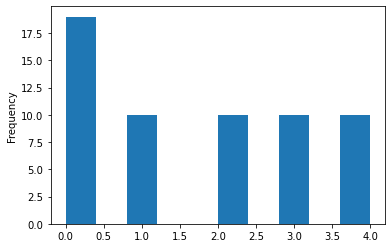

In [167]:
prediction_df.prefix_length.plot.hist()

In [168]:
prediction_df_melt = prediction_df.loc[:, prediction_df.columns.str.startswith(("prediction", "num_prefix_sentences", "prefix_length"))] \
    .melt(id_vars=["num_prefix_sentences", "prefix_length", "prefix_length_bin"],
          var_name="prediction", value_name="correct")

Text(0, 0.5, 'Prediction accuracy')

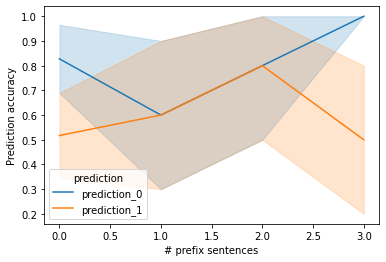

In [169]:
sns.lineplot(data=prediction_df_melt, x="num_prefix_sentences", y="correct", hue="prediction")

plt.xlabel("# prefix sentences")
plt.ylabel("Prediction accuracy")

In [170]:
# Too noisy. Use binned plot instead.
# sns.lineplot(data=prediction_df, x="prefix_length", y="prediction_0")

# plt.xlabel("# prefix tokens")
# plt.ylabel("Prediction accuracy")

Text(0, 0.5, 'Prediction accuracy')

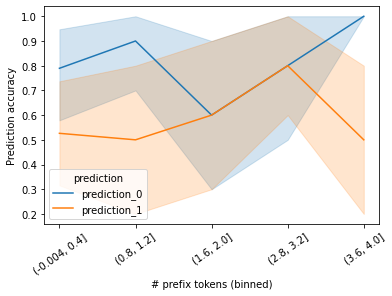

In [171]:
sns.lineplot(data=prediction_df_melt, x="prefix_length_bin", y="correct", hue="prediction")
plt.xticks(rotation=35)

plt.xlabel("# prefix tokens (binned)")
plt.ylabel("Prediction accuracy")

## Margins

In [185]:
region_dfs = [pd.read_csv(f"{suite}.regions.csv") for suite in suites]
region_df = pd.concat(region_dfs, names=["suite"], keys=suites)
# Bring in metadata from predictions df
region_df = pd.merge(region_df.reset_index(), prediction_df[["item_number", "prefix_length", "prefix_length_bin", "first_item", "num_prefix_sentences", "canonical_suite"]].reset_index(),
                     on=["suite", "item_number"])

region_df

,suite,level_1_x,item_number,value,condition,region_number,level_1_y,prefix_length,prefix_length_bin,first_item,num_prefix_sentences,canonical_suite
0,tst_number_prep,0,1,12.441164,match_sing,3,0,0,"(-0.004, 0.4]",1,0.0,number_prep
1,tst_number_prep,59,1,25.171421,match_sing,4,0,0,"(-0.004, 0.4]",1,0.0,number_prep
2,tst_number_prep,118,1,3.329726,match_sing,5,0,0,"(-0.004, 0.4]",1,0.0,number_prep
3,tst_number_prep,177,1,16.262009,match_sing,6,0,0,"(-0.004, 0.4]",1,0.0,number_prep
4,tst_number_prep,236,1,4.061763,match_sing,7,0,0,"(-0.004, 0.4]",1,0.0,number_prep
...,...,...,...,...,...,...,...,...,...,...,...,...
1883,tst_number_prep,1651,59,1.852680,mismatch_sing,2,58,4,"(3.6, 4.0]",14,3.0,number_prep
1884,tst_number_prep,1710,59,275.174316,match_plural,1,58,4,"(3.6, 4.0]",14,3.0,number_prep
1885,tst_number_prep,1769,59,1.852680,match_plural,2,58,4,"(3.6, 4.0]",14,3.0,number_prep
1886,tst_number_prep,1828,59,275.174316,mismatch_plural,1,58,4,"(3.6, 4.0]",14,3.0,number_prep


In [207]:
critical_region_df = region_df.groupby("suite", as_index=False).apply(lambda s: s[s.region_number == critical_regions[s.canonical_suite.iloc[0]]])
critical_region_df

suite  level_1_x  item_number      value        condition  \
0 4     tst_number_prep        236            1   4.061763       match_sing   
  10    tst_number_prep        590            1   6.222624    mismatch_sing   
  16    tst_number_prep        944            1   5.067435     match_plural   
  22    tst_number_prep       1298            1   8.553680  mismatch_plural   
  36    tst_number_prep        237            2  16.579683       match_sing   
...                 ...        ...          ...        ...              ...   
  1846  tst_number_prep       1355           58  19.320480  mismatch_plural   
  1860  tst_number_prep        294           59   1.838525       match_sing   
  1866  tst_number_prep        648           59   6.387265    mismatch_sing   
  1872  tst_number_prep       1002           59   2.813482     match_plural   
  1878  tst_number_prep       1356           59  18.091192  mismatch_plural   

        region_number  level_1_y  prefix_length prefix_length_bin first_item  \
0 4                 7          0              0     (-0.004, 0.4]          1   
  10                7          0              0     (-0.004, 0.4]          1   
  16                7          0              0     (-0.004, 0.4]          1   
  22                7          0              0     (-0.004, 0.4]          1   
  36                7          1              0     (-0.004, 0.4]          2   
...               ...        ...            ...               ...        ...   
  1846              7         57              4        (3.6, 4.0]          4   
  1860              7         58              4        (3.6, 4.0]         14   
  1866              7         58              4        (3.6, 4.0]         14   
  1872              7         58              4        (3.6, 4.0]         14   
  1878              7         58              4        (3.6, 4.0]         14   

        num_prefix_sentences canonical_suite  
0 4                      0.0     number_prep  
  10                     0.0     number_prep  
  16                     0.0     number_prep  
  22                     0.0     number_prep  
  36                     0.0     number_prep  
...                      ...             ...  
  1846                   3.0     number_prep  
  1860                   3.0     number_prep  
  1866                   3.0     number_prep  
  1872                   3.0     number_prep  
  1878                   3.0     number_prep  

[236 rows x 12 columns]

Text(0, 0.5, 'Raw surprisal')

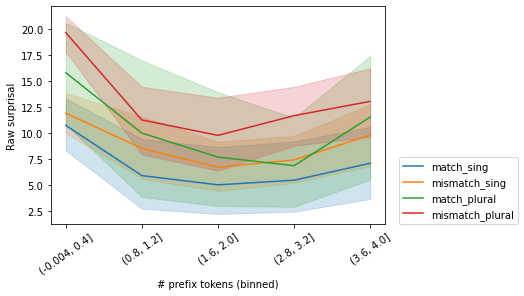

In [208]:
region_df["prefix_length_bin"] = pd.cut(region_df.prefix_length, 10).astype(str)
sns.lineplot(data=critical_region_df, x="prefix_length_bin", y="value", hue="condition")

plt.xticks(rotation=35)
plt.legend(loc=(1.04,0))
plt.xlabel("# prefix tokens (binned)")
plt.ylabel("Raw surprisal")

Text(28.155390625000003, 0.5, 'Raw surprisal')

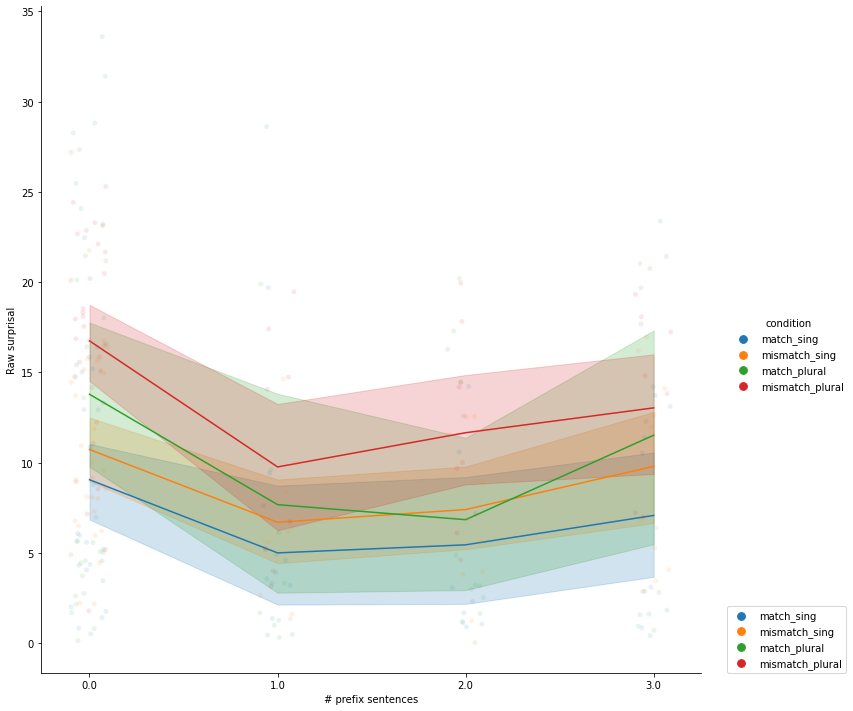

In [209]:
g = sns.catplot(data=critical_region_df, x="num_prefix_sentences", y="value", hue="condition", alpha=0.1,
                height=10)
sns.lineplot(data=critical_region_df, x="num_prefix_sentences", y="value", hue="condition", ax=g.ax, legend=False)

plt.legend(loc=(1.04,0))
plt.xlabel("# prefix sentences")
plt.ylabel("Raw surprisal")

In [221]:
def compute_margins(rows):
    rows = rows.set_index("condition").value
    return pd.Series({"sing": rows.loc["mismatch_sing"] - rows.loc["match_sing"],
                      "plur": rows.loc["mismatch_plural"] - rows.loc["match_plural"]})

margin_sizes = critical_region_df.groupby(["suite", "item_number"]).apply(compute_margins)
margin_sizes

sing       plur
suite           item_number                     
tst_number_prep 1            2.160861   3.486245
                2            0.212587  -9.230036
                3           -0.709087  -5.517756
                4            0.778837  -6.381565
                5           -4.087915   3.272254
                6            1.136472  -3.209274
                7            3.932321  19.629362
                8            2.982669  17.647597
                9            4.231819  18.293698
                10           0.796403  16.095556
                11           2.433845  15.138344
                12           5.435125  16.377278
                13           2.135710  18.688076
                14           0.914474  -7.587015
                15           0.985206  -8.649593
                16          -0.238607 -16.051855
                17          -4.533979  -7.150934
                18           0.895521 -11.201284
                19           2.855364  19.512466
                20           0.438910  10.261816
                21           5.894674   7.252641
                22           5.141681  -0.827962
                23          -0.636584  -2.737194
                24           4.314436  -3.860839
                25           4.632305  13.095085
                26           1.851393  -4.554764
                27           1.714219   5.050881
                28           2.453215   4.994684
                29           0.398405 -16.031923
                30           5.119624   3.015684
                31           0.547934 -13.874651
                32          -5.060717  -0.430260
                33           2.977858  14.080945
                34          -1.950135   3.903833
                35           5.012779   3.577857
                36           7.924162  -1.774343
                37          -1.259419  -2.862577
                38           5.652015   7.948932
                39          -1.988746   7.305081
                40           0.121965   7.145495
                41           2.912005   4.925372
                42           5.703979   7.725469
                43           4.550237   2.966290
                44           5.257859  14.831503
                45           4.570324   6.499682
                46          -2.670635  -0.043680
                47           1.934505  -6.016044
                48          -3.725623   2.654539
                49           0.880772   7.481559
                50           4.884935   1.925457
                51           2.613399   6.284650
                52           2.123449  -6.219067
                53           2.769554  -4.179934
                54           0.580131 -11.086803
                55           3.071010  -3.080273
                56           3.746161   4.346136
                57           2.457882  12.249202
                58           0.389248  -0.364922
                59           4.548739  15.277710

In [222]:
margin_sizes = pd.merge(margin_sizes.reset_index(), prediction_df[["item_number", "prefix_length", "first_item", "canonical_suite"]].reset_index(),
                        on=["suite", "item_number"])
margin_sizes

,suite,item_number,sing,plur,level_1,prefix_length,first_item,canonical_suite
0,tst_number_prep,1,2.160861,3.486245,0,0,1,number_prep
1,tst_number_prep,2,0.212587,-9.230036,1,0,2,number_prep
2,tst_number_prep,3,-0.709087,-5.517756,2,0,3,number_prep
3,tst_number_prep,4,0.778837,-6.381565,3,0,4,number_prep
4,tst_number_prep,5,-4.087915,3.272254,4,0,5,number_prep
5,tst_number_prep,6,1.136472,-3.209274,5,0,6,number_prep
6,tst_number_prep,7,3.932321,19.629362,6,0,7,number_prep
7,tst_number_prep,8,2.982669,17.647597,7,0,8,number_prep
8,tst_number_prep,9,4.231819,18.293698,8,0,9,number_prep
9,tst_number_prep,10,0.796403,16.095556,9,0,10,number_prep


In [223]:
# Prefer binned figure below.

# sns.lineplot(data=margin_sizes.melt(id_vars=["prefix_length"], value_vars=["sing", "plur"], var_name="Prediction"),
#              x="prefix_length", y="value", hue="Prediction")

# plt.legend(loc=(1.04, 0))
# plt.axhline(0, color="gray", linestyle="--")
# plt.xlabel("# prefix tokens")
# plt.ylabel("Grammaticality margin (bits)")

Text(25.045026041666667, 0.5, 'Grammaticality margin (bits)')

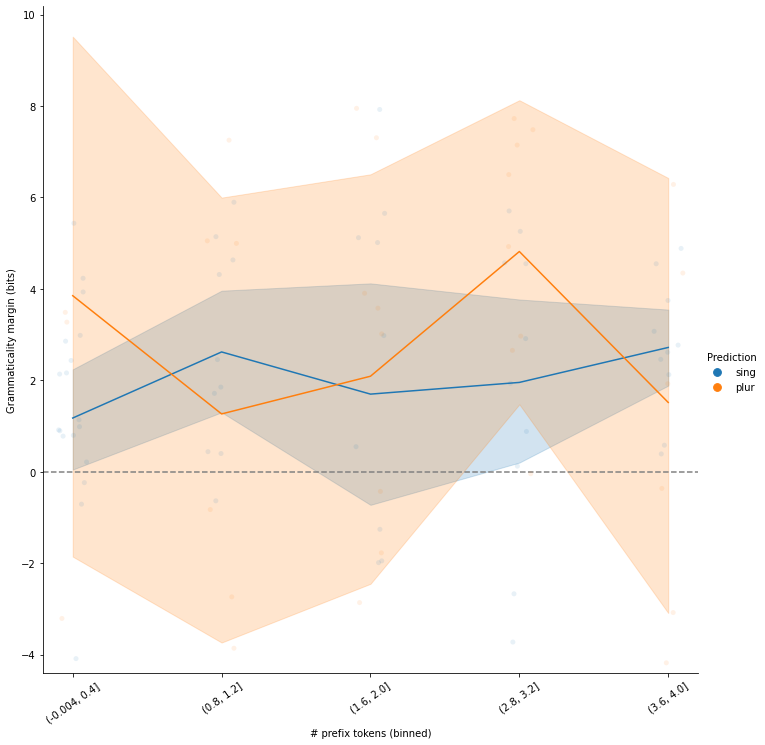

In [224]:
margin_sizes["prefix_length_bin"] = pd.cut(margin_sizes.prefix_length, 10).astype(str)
g = sns.catplot(data=margin_sizes.melt(id_vars=["prefix_length_bin"], value_vars=["sing", "plur"], var_name="Prediction"),
                x="prefix_length_bin", y="value", hue="Prediction", alpha=0.1, height=10)
sns.lineplot(data=margin_sizes.melt(id_vars=["prefix_length_bin"], value_vars=["sing", "plur"], var_name="Prediction"),
             x="prefix_length_bin", y="value", hue="Prediction", ax=g.ax, legend=False)

plt.axhline(0, color="gray", linestyle="--")
plt.xticks(rotation=35)
plt.xlabel("# prefix tokens (binned)")
plt.ylabel("Grammaticality margin (bits)")

In [225]:
# DEV recompute predictions as a sanity check
recompute_preds = margin_sizes.assign(correct_0=(margin_sizes.sing > 0),
                                      correct_1=(margin_sizes.plur > 0))

<AxesSubplot:xlabel='prefix_length_bin', ylabel='value'>

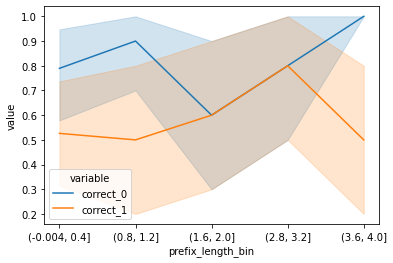

In [226]:
sns.lineplot(data=recompute_preds[["prefix_length_bin", "correct_0", "correct_1"]].melt(id_vars=["prefix_length_bin"]),
             x="prefix_length_bin", y="value", hue="variable")

In [227]:
# recompute_preds[recompute_preds.prefix_length == 0].groupby("canonical_suite").correct.mean()
recompute_preds[recompute_preds.prefix_length == 0][["correct_0", "correct_1"]].melt().groupby("variable").value.mean()

variable
correct_0    0.789474
correct_1    0.526316
Name: value, dtype: float64